<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span><ul class="toc-item"><li><span><a href="#Filter" data-toc-modified-id="Filter-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filter</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Grid-Wrapper" data-toc-modified-id="Grid-Wrapper-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Grid Wrapper</a></span></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Options</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span><ul class="toc-item"><li><span><a href="#Test-plotting" data-toc-modified-id="Test-plotting-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Test plotting</a></span></li></ul></li></ul></div>

# Clustering

## Description

- Cluster funds using Spektral Clustering

## Setup

In [1]:
import feather
from itertools import product
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from scipy.spatial.distance import euclidean

from minisom import MiniSom

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [2]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)
le = LabelEncoder()
row_info['lipper_class_num'] = le.fit_transform(row_info['lipper_class'])

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

## Other functions

### Filter

In [3]:
def filter_data(param, verbose = False):
    
    verbose = param['verbose']
    year = param['year']
        
    row_info_f = row_info.copy()
    if (year != 'full'):    # If year = full take whole sample
        row_info_f = row_info_f.query('year == @year')

    begin_date = row_info_f.iloc[0,:]['report_dt']
    end_date = begin_date + pd.DateOffset(years=1) # 1 year offset
    row_info_f.reset_index(drop = True, inplace=True)

    # Filter returns
    crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
    returns_f = returns.copy()
    query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
    returns_f = returns_f.query(query)

    # Change return of month for which holdings apply to 0
    returns_f = returns_f.copy()
    mask = returns_f['report_dt'] == begin_date
    returns_f.loc[mask,'mret'] = 0
    
    # Drop all funds with first return observation after starting date
    drop_fundnos = returns_f.drop_duplicates('crsp_fundno').query('mret != 0')['crsp_fundno']
    returns_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    row_info_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    
    # Filter holdings accordingly and delet all securities with less than two observations
    holdings_f = holdings.copy()
    holdings_f = holdings[row_info_f['row']]
    
    holdings_b = sparse.csr_matrix(holdings_f, copy=True)
    holdings_b.data = np.ones(len(holdings_f.data))

    sum_sec_boolean = holdings_b.toarray().sum(0)
    col_mask = (sum_sec_boolean >= 2).flatten()

    holdings_f = holdings_f.tocsc()
    holdings_f = holdings_f[:,col_mask]
    holdings_f = holdings_f.tocsr()
    
    ## Preprocessing
    holdings_ft = normalize(holdings_f)
    
    if (verbose):
        print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))

        print('Numer of unique securities:      {:10,d}'.format(holdings_ft.shape[1]))

        print('Begin date:                      {}'.format(begin_date.date()))
        print('End date:                        {}'.format(end_date.date()))
    
    return(row_info_f, returns_f, holdings_ft, begin_date, end_date)

### Clustering

In [4]:
def spectral_clustering(holdings_ft, param):
    verbose = param['verbose']

    if(verbose): print('Start clustering...')
    clustering = SpectralClustering(n_clusters = param['n_clusters'],
                                    assign_labels = param['assign_labels'], # kmeans or discretize
                                    eigen_solver = 'arpack',
                                    affinity = param['affinity'],
                                    gamma = param['gamma'],
                                    n_init = param['n_init'],
                                    n_jobs = -1,
                                    random_state = 0).fit(holdings_ft)
    if(verbose): print('Clustering finished')
    
    return(clustering)

In [5]:
def kmeans_clustering(holdings_ft, param):
    verbose = param['verbose']

    if(verbose): print('Start clustering...')
    clustering = KMeans(n_clusters = param['n_clusters'],
                        verbose = verbose,
                        n_init = param['n_init'], # Number of runs
                        n_jobs= -1,
                        random_state = 1
                       ).fit(holdings_ft)
    
    if(verbose): print('Clustering finished')
    
    return(clustering)

In [6]:
def som_clustering(holdings_ft, param):
    verbose = param['verbose']
    if(verbose): print('Start clustering...')
    
    ### Initialization and training ###
    # Configure SOM
    som = MiniSom(x = 25,
                  y = 25,
                  input_len = holdings_ft.shape[1],
    #             neighborhood_function = 'triangle',
                  sigma = 2.0,
                  learning_rate = 0.5)

    # Initialize
    data = holdings_ft.toarray()
    som.random_weights_init(data)

    # Train
    som.train_random(data, param['training_epochs'], verbose = verbose) # training with 100 iterations
    
    som_quantized = som.quantization(data)

    clustering = KMeans(n_clusters = param['n_clusters'],
                        verbose = verbose,
                        n_init = param['n_init'], # Number of runs
                        n_jobs= -1,
                        random_state = 1
                       ).fit(som_quantized)

    if(verbose): print('Clustering finished')    
    return(clustering)

### Evaluation

In [7]:
def calc_styleadj_returns(row_info_f, returns_f, style_cols):

    row_info_m = row_info_f.copy()
    returns_m = returns_f.copy()
    
    returns_m = returns_m.sort_values(['crsp_fundno','report_dt'])

    # merge predicted styles onto returns
    returns_m = returns_m.merge(row_info_m[['crsp_fundno', 'report_dt', style_cols]],
                            how='left',
                            on=['crsp_fundno', 'report_dt'])

    # Forward fill all styles and drop nas
    returns_m = (returns_m.apply(lambda x: x.fillna(method = 'ffill'))
    )

    # Calc mean return per style
    style_returns = (returns_m
                        .groupby([style_cols,'report_dt'])
                        .mean()
                        .reset_index()
                        .drop(columns='crsp_fundno')
    )

    # Merge style returns onto fund returns and calc tracking error
    returns_m = (returns_m
                        .rename(columns = {'mret' : 'fund_ret'}) 
                        .merge(style_returns,
                                    how = 'left',
                                    on = [style_cols,'report_dt'])
                        .assign(error = lambda df: df['fund_ret'] - df['mret'])
                        .rename(columns = {'mret' : 'style_ret'}) 
    )

    returns_m = returns_m[['crsp_fundno', 'report_dt', style_cols,
                       'fund_ret', 'style_ret', 'error']]

    return(returns_m, style_returns)

In [8]:
def error_vola_deciles(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    
    error_vol = (error_vol[['error']]
                .apply(lambda x : x.quantile(np.round(np.arange(0.1,1,0.1),2))))
    return(error_vol)

def error_vola_describe(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    return(error_vol[['error']].describe().T)

In [9]:
def simulation(row_info_f, returns_f, n_iterations):
    np.random.seed()

    #n_iterations = 500
    
    # First choose n samples of funds with one fund per cluster
    funds_list = []
    cluster = np.array(row_info_f[['crsp_fundno','cluster']])
    arr = np.arange(row_info_f.shape[0])

    for i in np.arange(n_iterations):
        np.random.shuffle(arr)
        cluster = cluster[arr]
        index = np.unique(cluster[:,1], return_index = True, return_inverse = False)[1]
        funds = cluster[index,0]
        funds_list.append(funds)


    mean_return = []
    mean_std = []
    returns_fundnos = returns_f['crsp_fundno'].values

    for funds in funds_list:
        # Take returns for sample and calc equally weighted average return
        returns_index = np.isin(returns_fundnos,funds)
        returns_s = returns_f[returns_index]
        returns_s = returns_s.groupby('report_dt')['mret'].mean()

        # Calc mean and std
        mean_return.append(returns_s.std())
        mean_std.append(returns_s.mean())


    mean_return = pd.DataFrame(mean_return).mean()
    mean_std = pd.DataFrame(mean_std).mean()
    
    return([mean_return[0], mean_std[0]])

In [10]:
def simulation_wrapper(row_info_f, returns_f, n_iterations):
    result_list = []
    pool = Pool()
    
    for i in range(n_iterations):
        pool.apply_async(simulation, callback = result_list.append)
    pool.close()
    pool.join()
    result = result_list
    return(result)

### Plotting

In [11]:
def style_map(row_info_f):
    cap = [0,1,2,3]
    style = [0,1,2]

    counts = row_info_f['cluster'].value_counts().sort_index()
    size = np.round(counts / 10)

    data = round(
            pd.crosstab(
                row_info_f['cap_class'],row_info_f['cluster'], 
                margins = True, normalize = 'columns') * 100, 2).T

    x = data.apply(lambda x: np.sum(x * cap) / 100, axis = 1)

    data = round(
            pd.crosstab(
                row_info_f['style_class'],row_info_f['cluster'], 
                margins = True, normalize = 'columns') * 100, 2).T
    y = data.apply(lambda x: np.sum(x * style) / 100, axis = 1)

    label = x.index[:-1]

    fig = plt.figure(figsize=(15,4))
    ax_s = fig.add_subplot(111)

    #ax_s.grid(True)

    plt.xlabel('Market cap dimension')
    plt.xticks([0,1,2,3], ['SC','MC','ML','LC'])

    plt.ylabel('Style dimension')
    plt.yticks([0,1,2], ['V','C','G'])

    for i, txt in enumerate(label):
        ax_s.annotate(txt, (x[i], y[i]),
                     xytext = (0, 0),              # Horizontally shift label by `space`
                     textcoords = 'offset points', # Interpret `xytext` as offset in points
                     va='center',                  # Vertically center label
                     ha='center',
                     color = 'black',
                     size = size[i])  

    plt.show()
    
def plot_cluster(row_info_f, style, ax):
    data = round(
        pd.crosstab(
            row_info_f[style],row_info_f['cluster'], 
            margins = True, normalize = 'columns') * 100, 2).T

    data.plot(kind='bar', 
                 stacked=True, ax = ax)

    ax.legend().remove()
    label_list = data.columns.values.astype(str).repeat(data.shape[0])
    rects = ax.patches

    # For each bar: Place a label
    for i, rect in enumerate(rects):
        if rect.get_height() > 10:
            # Get X and Y placement of label from rect.
            x_value = rect.get_x() + rect.get_width() / 2
            y_value = rect.get_y() + rect.get_height() / 2

            # Use X value as label and format number with one decimal place
            label = "{}".format(label_list[i])

            # Create annotation
            ax.annotate(
                label,                        # Use `label` as label
                (x_value, y_value),           # Place label at end of the bar
                xytext = (0, 0),              # Horizontally shift label by `space`
                textcoords = 'offset points', # Interpret `xytext` as offset in points
                va='center',                  # Vertically center label
                ha='center',
                color = 'white',
                size = 12)                  # Horizontally align label 
    return(ax)
    
def plot_cluster_wrapper(row_info_f):
    
    f, axes = plt.subplots(nrows = 4, ncols=1, sharex=True, 
                           figsize = (15,6), gridspec_kw={'height_ratios':[1,2,2,2]})
    
    data = row_info_f['cluster'].value_counts(sort=False).append(to_append = pd.Series([0]))
    data.plot(kind='bar', ax = axes[0])
    axes[0].annotate('Total: {:,d}'.format(np.sum(data)),(12,100),ha ='center',size=14)

    plot_cluster(row_info_f,'cap_class', ax = axes[1])
    plot_cluster(row_info_f,'style_class', ax = axes[2])
    plot_cluster(row_info_f,'lipper_class', ax = axes[3])
    plt.show()
    style_map(row_info_f)

### Grid Wrapper

In [12]:
def expand_grid(dictionary):
    temp = pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())
    return(temp)

In [13]:
def weighted_average_score(param_grid, relevant_params, measures):


    param_grid['param_id'] = (param_grid
                                  .groupby(relevant_params)
                                  .ngroup())
        
    scores = param_grid[measures]
    params_only = param_grid.drop(columns = measures)
    
    weights = (param_grid[['year','count']]
                                  .drop_duplicates()
                                  .assign(weight = lambda x: x['count'] / np.sum(x['count'])))
    weights = weights[['weight']].values

    scores = scores.groupby(params_only['param_id']).apply(lambda x: np.sum(x * weights))

    params_only = (params_only
                      .drop_duplicates(relevant_params)
                      .drop(columns = ['year','count']))

    result = params_only.merge(scores, how = 'left', on = 'param_id')
    
    return(result)

In [14]:
def full_algo(param_grid):
    
    # Setup
    n_row = param_grid.shape[0]
    cluster_list = []
    result_grid = param_grid.copy()
    
    # Loop over all supplyed params
    print('Start with params...')
    for i, param in param_grid.iterrows():
        row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param)
        
        algo = param['algo']
        if(algo == 'spectral'): clustering = kmeans_clustering(holdings_ft, param)
        if(algo == 'kmeans'):   clustering = spectral_clustering(holdings_ft, param)
        if(algo == 'som'):      clustering = som_clustering(holdings_ft, param)

        row_info_f = row_info_f.assign(cluster = clustering.labels_)
        cluster_list.append(clustering.labels_)

        db_score = davies_bouldin_score(holdings_ft.toarray(), row_info_f['cluster'])
        s_score = silhouette_score(holdings_ft, row_info_f['cluster'])

        result_grid.loc[i,'count'] = row_info_f.shape[0]
        result_grid.loc[i,'score db'] = db_score
        result_grid.loc[i,'score silhouette'] = s_score

        sim_results = simulation(row_info_f, returns_f, n_iterations = 500)
        result_grid.loc[i,'sim mret'] = sim_results[0]
        result_grid.loc[i,'sim std'] = sim_results[1]

        returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_cols='cluster')
        result_grid.loc[i,'median tevola'] = error_vola_describe(returns_m)['50%'][0]
        
        progress = (i+1) / n_row * 100
        print('Progress:                                          {:<5.2f}%'.format(progress))
    
    print('Evaluate Lipper clusters...')
    # Evaluate standart lipper classification
    years = param_grid['year'].unique()

    lipper_grid = pd.DataFrame()
    param_lipper = dict(
                    year = years,
                    verbose = [False]
                    )
    param_grid_lipper = expand_grid(param_lipper)
        
    for i, param_lipper in param_grid_lipper.iterrows():
        row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param_lipper)
        row_info_f = row_info_f.assign(cluster = row_info_f['lipper_class_num'])
        cluster_list.append(row_info_f['lipper_class_num'])

        db_score = davies_bouldin_score(holdings_ft.toarray(), row_info_f['cluster'])
        s_score = silhouette_score(holdings_ft, row_info_f['cluster'])

        lipper_grid.loc[i,'year'] = param_lipper['year']
        lipper_grid.loc[i,'count'] = row_info_f.shape[0]
        lipper_grid.loc[i,'score db'] = db_score
        lipper_grid.loc[i,'score silhouette'] = s_score

        sim_results = simulation(row_info_f, returns_f, n_iterations = 500)
        lipper_grid.loc[i,'sim mret'] = sim_results[0]
        lipper_grid.loc[i,'sim std'] = sim_results[1]
        lipper_grid.loc[i,'algo'] = 'lipper'
        
        returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_cols='cluster')
        lipper_grid.loc[i,'median tevola'] = error_vola_describe(returns_m)['50%'][0]
        
    # Concat and calc year weighted averages
    param_grid_full = pd.concat([result_grid,lipper_grid], axis = 0, sort=False)
    result = weighted_average_score(param_grid_full,
                                    relevant_params = ['n_clusters','assign_labels',
                                                       'affinity','gamma','n_init','algo'], 
                                    measures = ['score db', 'score silhouette', 'sim mret', 
                                                'sim std', 'median tevola'])
    result = result.drop(columns = ['verbose'])
    result['years'] = '{} - {}'.format(np.min(years), np.max(years))
    print('                                              ... Finished')

    return(result, cluster_list)

## Clustering

### Options

In [15]:
full = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
param = dict(
    year             = [2014, 2015, 2016],          # Integer or string 'full' for the whole sample
    algo             = ['kmeans','som','spectral'],    # 'kmeans','spectral','som'
    n_clusters       = [12], 
    n_init           = [200],             # N init of kmeans
    
    # spectral specific
    assign_labels    = ['kmeans'],      # 'kmeans' or 'discretize'
    affinity         = ['rbf'],         # One of: rbf, nearest_neighbors
    gamma            = [1],             # Sigma for rbf kernal

    # som specific
    training_epochs  = [1_000],
    
    verbose          = [True]
)

param_grid = expand_grid(param)

In [16]:
result, cluster_list = full_algo(param_grid)

Start with params...
Numer of unique funds:                1,989
Numer of unique securities:           5,319
Begin date:                      2014-12-31
End date:                        2015-12-31
Start clustering...
Clustering finished
Progress:                                          11.11%
Numer of unique funds:                1,989
Numer of unique securities:           5,319
Begin date:                      2014-12-31
End date:                        2015-12-31
Start clustering...
 [ 1000 / 1000 ] 100% - 34.05 it/s - 0:00:00 left  - quantization error: 0.8367010754320432
Clustering finished
Progress:                                          22.22%
Numer of unique funds:                1,989
Numer of unique securities:           5,319
Begin date:                      2014-12-31
End date:                        2015-12-31
Start clustering...
Clustering finished
Progress:                                          33.33%
Numer of unique funds:                1,836
Numer of unique secur

In [17]:
result

,algo,n_clusters,n_init,assign_labels,affinity,gamma,training_epochs,param_id,score db,score silhouette,sim mret,sim std,median tevola,years
0,kmeans,12.0,200.0,kmeans,rbf,1.0,1000.0,0,4.290192,0.017015,0.030228,0.007170,0.946932,2014 - 2016
1,som,12.0,200.0,kmeans,rbf,1.0,1000.0,1,5.529467,0.014435,0.030385,0.006923,0.940262,2014 - 2016
2,spectral,12.0,200.0,kmeans,rbf,1.0,1000.0,2,5.022871,0.023694,0.030600,0.006906,0.902950,2014 - 2016
3,lipper,NaN,NaN,NaN,NaN,NaN,NaN,-1,7.299811,0.011866,0.031603,0.006968,0.912074,2014 - 2016


## Visualize

In [164]:
model_index = 0
cluster = cluster_list[model_index]
param = param_grid.iloc[model_index,:]

In [165]:
row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param)
row_info_f = row_info_f.assign(cluster = cluster)

Numer of unique funds:                1,914
Numer of unique securities:           5,229
Begin date:                      2016-09-30
End date:                        2017-09-30


In [162]:
result

,algo,n_clusters,n_init,assign_labels,affinity,gamma,training_epochs,param_id,score db,score silhouette,sim mret,sim std,median tevola,years
0,som,9.0,300.0,kmeans,rbf,1.0,10000.0,0,4.994928,0.034648,0.020960,0.013197,0.888966,2016 - 2016
1,lipper,NaN,NaN,NaN,NaN,NaN,NaN,-1,7.173288,0.013210,0.021991,0.013057,0.874125,2016 - 2016


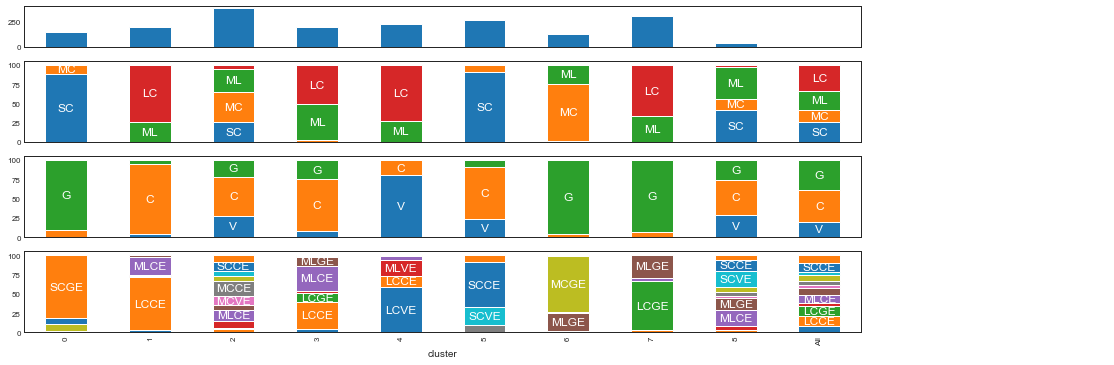

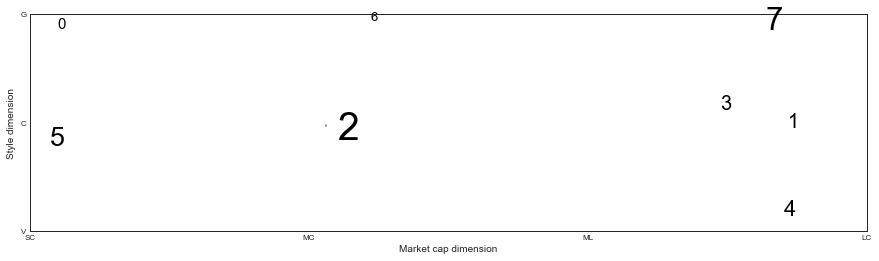

In [166]:
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})

plot_cluster_wrapper(row_info_f)

### Test plotting

ValueError: Could not interpret input 'DB score'

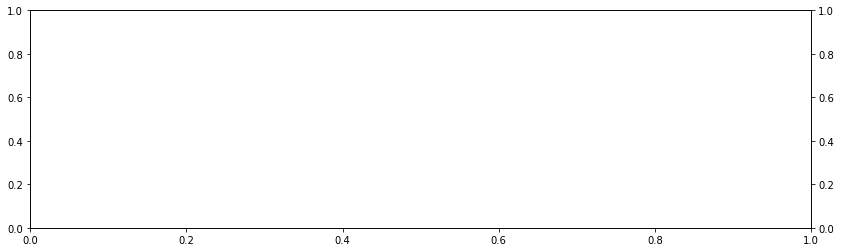

In [46]:
fig, ax1 = plt.subplots(figsize = (14,4))

ax2 = ax1.twinx()

sns.lineplot(data = result ,x = 'n_clusters', y='DB score', color='g', ax=ax1)
sns.lineplot(data = result ,x = 'n_clusters', y='Silhouette score', ax=ax2)

ax1.set_xlabel('n_cluster')
ax1.set_ylabel('DB score', color='g')
ax2.set_ylabel('Slihouette score', color='b')

plt.show()

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Spectral" data-toc-modified-id="Spectral-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Spectral</a></span></li><li><span><a href="#K-means" data-toc-modified-id="K-means-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>K-means</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span></li><li><span><a href="#Chart-the-returns-of-the-formed-clustes" data-toc-modified-id="Chart-the-returns-of-the-formed-clustes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Chart the returns of the formed clustes</a></span></li><li><span><a href="#Analysing-clusters" data-toc-modified-id="Analysing-clusters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analysing clusters</a></span></li></ul></div>